In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
user = "aabounak"
password = "mysecretpassword"
host = "localhost"
port = "5432"
database = "piscineds"

def connect_to_postgres():
  return create_engine(
    url=f"postgresql://{user}:{password}@{host}:{port}/{database}"
  )

In [3]:
engine = connect_to_postgres()

In [4]:
with engine.connect() as connection:
  result = connection.execute(text('select * from customers'))
  data = result.fetchall()

columns_names = result.keys()
df = pd.DataFrame(data, columns=columns_names)
df.head()

--- FInished ---


,event_time,event_type,product_id,price,user_id,user_session,category_id,category_code,brand
0,2022-12-01 00:37:47+00:00,view,5838656,15.24,557516335,5d652b2d-7f7b-488f-a2a4-73e12c024596,NaN,None,None
1,2022-12-01 00:37:49+00:00,cart,5908215,1.43,356011474,e38133d8-bd17-e4e1-194f-e01d325312db,1.487580e+18,None,None
2,2022-12-01 00:38:08+00:00,view,5861591,2.22,555562373,be19f337-027d-48a8-b394-bc3a76f9a560,NaN,None,None
3,2022-12-01 00:38:13+00:00,cart,5735080,2.38,513026898,2b88b00a-892a-4639-bce4-1ea17a7d6221,1.487580e+18,None,None
4,2022-12-01 00:40:47+00:00,cart,5834733,0.79,514615315,effdfe46-c037-4190-b5c6-f089fe363fca,NaN,None,None


### Exercise 00

<AxesSubplot: ylabel='event_type'>

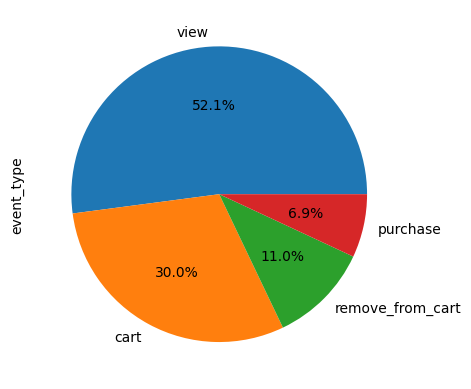

In [5]:
df['event_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

### Exercise 01

In [48]:
df['event_time'] = pd.to_datetime(df['event_time'])
filtered_data = df[(df['event_type'] == 'purchase')]

/var/folders/6s/mx7pbvk52nv491g2tc_gtggw0000gn/T/ipykernel_36144/4248519440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_time'] = pd.to_datetime(df['event_time'])


In [195]:
filtered_data['year'] = filtered_data['event_time'].dt.year
filtered_data['month'] = filtered_data['event_time'].dt.month
filtered_data['day'] = filtered_data['event_time'].dt.day

<AxesSubplot: xlabel='Date', ylabel='Number of customers'>

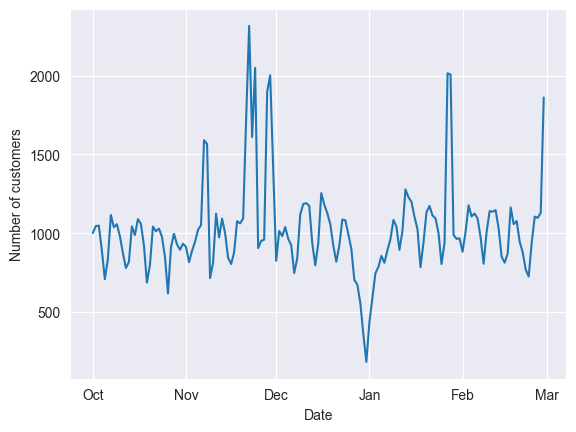

In [201]:
daily_customer_counts = filtered_data.groupby(['year', 'month', 'day'])['user_id'].nunique().reset_index()
daily_customer_counts['date'] = pd.to_datetime(daily_customer_counts[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

plt.ylabel('Number of customers')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

sns.lineplot(data=daily_customer_counts, x='date', y='user_id')

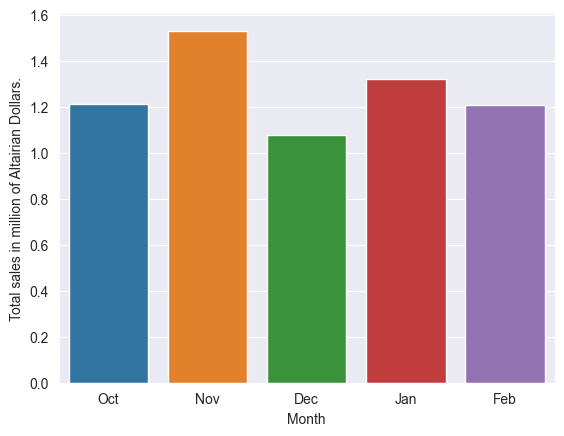

In [202]:
total_sales = filtered_data.groupby(['year', 'month'])['price'].sum().reset_index()
total_sales['date'] = pd.to_datetime(total_sales[['year', 'month']].astype(str).agg('-'.join, axis=1)).dt.strftime('%b')

total_sales['price_in_million'] = total_sales['price'] / 1000000

sns.barplot(data=total_sales, x='date', y='price_in_million')

plt.xlabel('Month')
plt.ylabel('Total sales in million of Altairian Dollars.')
plt.show()

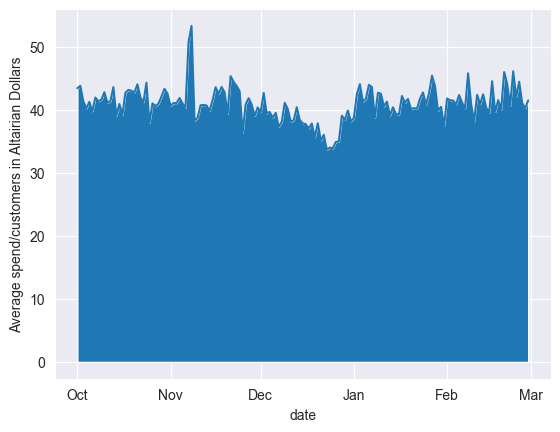

In [211]:
total_sales = filtered_data.groupby(['year', 'month', 'day'])['price'].sum().reset_index()
merged_data = pd.merge(total_sales, daily_customer_counts, on=['year', 'month', 'day'])
merged_data['average_spend_per_customer'] = merged_data['price'] / merged_data['user_id']
merged_data['date'] = pd.to_datetime(merged_data[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

sns.lineplot(data=merged_data, x='date', y='average_spend_per_customer')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.fill_between(merged_data['date'], merged_data['average_spend_per_customer'])
plt.ylabel('Average spend/customers in Altairian Dollars')
plt.show()
